In [ ]:
import sys
nb_path = "/content/drive/My Drive/Colab Notebooks"
if nb_path not in sys.path:
  sys.path.insert(5, nb_path)

In [ ]:
!pip install scikit-surprise --target="{nb_path}"

In [ ]:
!pip install scikit-surprise

# Importing the necessary libraries

In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import pandas as pd
import numpy as np
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

sns.set_style('darkgrid')

# Loading the datasets

In [ ]:
df_books = pd.read_excel('BX_Books.xlsx')
df_ratings = pd.read_excel('BX_ratings.xlsx')

In [ ]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,NaN,NaN,NaN
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,NaN,NaN,NaN
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,NaN,NaN,NaN
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,NaN,NaN,NaN
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,NaN,NaN,NaN


In [ ]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


## Let's drop the unwanted columns

In [ ]:
df_books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], axis= 1, inplace = True)

## Merging the data on the book-id for future use

In [ ]:
df = df_books.merge(df_ratings, on='ISBN', how= 'inner')

In [ ]:
df_ratings['Book-Rating'] = df_ratings['Book-Rating'] + 1

In [ ]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,1
1,276726,155061224,6
2,276727,446520802,1
3,276729,052165615X,4
4,276729,521795028,7


In [ ]:
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2,0
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
2,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11400,0
3,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8
4,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,41385,0


In [ ]:
df_books.__len__(), df_ratings.__len__()

(271379, 1048575)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941149 entries, 0 to 941148
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 941149 non-null  object
 1   Book-Title           941143 non-null  object
 2   Book-Author          941148 non-null  object
 3   Year-Of-Publication  941149 non-null  object
 4   Publisher            941147 non-null  object
 5   User-ID              941149 non-null  int64 
 6   Book-Rating          941149 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 57.4+ MB


In [ ]:
books = df_ratings['ISBN'].value_counts()>=20
books = books[books].index.tolist()

In [ ]:
users = df_ratings['User-ID'].value_counts() >= 20
users = users[users].index.tolist()

In [ ]:
books.__len__(), users.__len__()

(6693, 6691)

In [ ]:
ratings_w_titles = df[(df['ISBN'].isin(books)) & (df['User-ID'].isin(users))]

In [ ]:
ratings_w_titles.__len__()

250246

In [ ]:
ratings_w_titles.reset_index(drop= True, inplace= True)

In [ ]:
ratings_w_titles['User-ID'].value_counts().tail()

227835    1
72780     1
73464     1
76798     1
40043     1
Name: User-ID, dtype: int64

In [ ]:
ratings_w_titles.describe()

,User-ID,Book-Rating
count,250246.000000,250246.000000
mean,128070.973326,2.527117
std,73911.323441,3.793670
min,242.000000,0.000000
25%,62862.000000,0.000000
50%,127623.000000,0.000000
75%,192245.000000,7.000000
max,278851.000000,10.000000


In [ ]:
ratings_w_titles['ISBN'].nunique(), ratings_w_titles['User-ID'].nunique()

(6508, 6444)

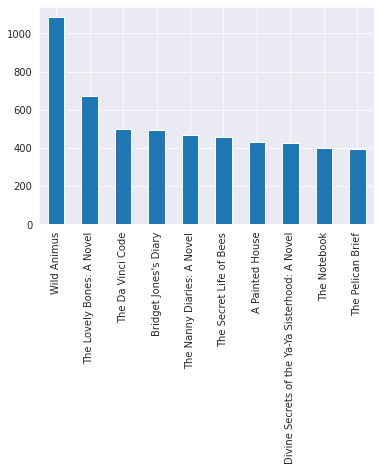

In [ ]:
ratings_w_titles['Book-Title'].value_counts()[:10].plot(kind = 'bar')

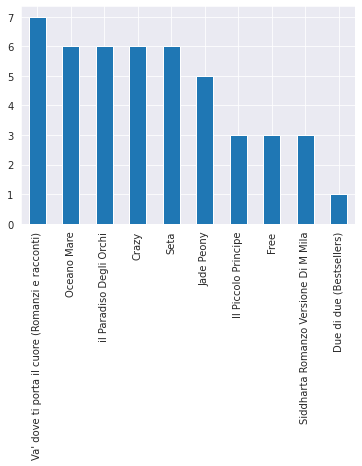

In [ ]:
ratings_w_titles['Book-Title'].value_counts()[-10:].plot(kind = 'bar')

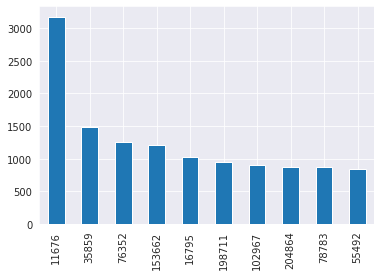

In [ ]:
ratings_w_titles['User-ID'].value_counts()[:10].plot(kind = 'bar')

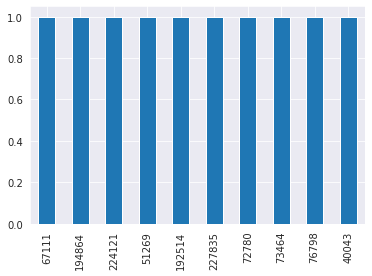

In [ ]:
ratings_w_titles['User-ID'].value_counts()[-10:].plot(kind = 'bar')

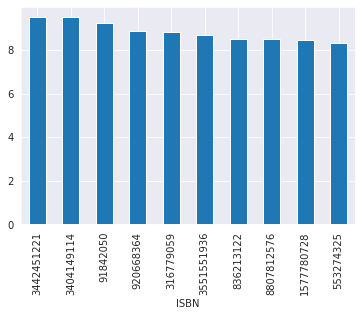

In [ ]:
ratings_w_titles.groupby(['ISBN'])['Book-Rating'].mean().sort_values(ascending = False)[:10].plot(kind = 'bar')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


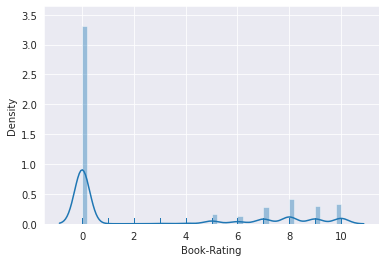

In [ ]:
sns.distplot(ratings_w_titles['Book-Rating'], rug = True)

# Popularity based Recommendation System

In [ ]:
df_train, df_test = train_test_split(ratings_w_titles, test_size=0.2,random_state = 41)

In [ ]:
class Popularity_Recommender():
    def __init__(self):
        self.df_train = None
        self.user_id = None
        self.product_id = None
        self.book_title = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, df_train, user_id, product_id, book_title):
        self.df_train = df_train
        self.user_id = user_id
        self.product_id = product_id
        self.book_title = book_title

        #Get a count of user_ids for each unique product as recommendation score
        train_data_grouped = df_train.groupby([self.product_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'User-ID': 'Score'},inplace=True)
        train_data_grouped[self.book_title] = df_train.groupby([self.product_id])[self.book_title]
        train_data_grouped[self.book_title] = train_data_grouped[self.book_title].apply(lambda x: x[1].reset_index()[self.book_title][0])
        print(train_data_grouped.head())
    
        #Sort the products based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['Score', self.product_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['Score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['User-ID'] = user_id
        
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations

In [ ]:
pop_recommend = Popularity_Recommender()
pop_recommend.create(df_train, 'User-ID', 'ISBN', 'Book-Title')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


      ISBN  Score                     Book-Title
0  6547834     19  Miss Smillas Feeling for Snow
1  6550576     17                     Red Leaves
2  6550789     18                            253
3  7110928     15                          Billy
4  7141076     12                Unless: A Novel


In [ ]:
pop_recommend.recommend(ratings_w_titles['User-ID'].unique()[1])

,User-ID,ISBN,Score,Book-Title,Rank
5634,29526,971880107,865,Wild Animus,1.0
876,29526,316666343,535,The Lovely Bones: A Novel,2.0
1916,29526,385504209,394,The Da Vinci Code,3.0
169,29526,60928336,333,Divine Secrets of the Ya-Ya Sisterhood: A Novel,4.0
693,29526,312195516,322,The Red Tent (Bestselling Backlist),5.0
6409,29526,067976402X,301,Snow Falling on Cedars,6.0
618,29526,142001740,299,The Secret Life of Bees,7.0
6224,29526,044021145X,290,The Firm,8.0
2477,29526,440211727,280,A Time to Kill,9.0
4469,29526,671027360,278,Angels &amp; Demons,10.0


In [ ]:
pop_recommend.recommend(ratings_w_titles['User-ID'].unique()[4])

,User-ID,ISBN,Score,Book-Title,Rank
5634,49300,971880107,865,Wild Animus,1.0
876,49300,316666343,535,The Lovely Bones: A Novel,2.0
1916,49300,385504209,394,The Da Vinci Code,3.0
169,49300,60928336,333,Divine Secrets of the Ya-Ya Sisterhood: A Novel,4.0
693,49300,312195516,322,The Red Tent (Bestselling Backlist),5.0
6409,49300,067976402X,301,Snow Falling on Cedars,6.0
618,49300,142001740,299,The Secret Life of Bees,7.0
6224,49300,044021145X,290,The Firm,8.0
2477,49300,440211727,280,A Time to Kill,9.0
4469,49300,671027360,278,Angels &amp; Demons,10.0


In [ ]:
pop_recommend.recommend(ratings_w_titles['User-ID'].unique()[9])

,User-ID,ISBN,Score,Book-Title,Rank
5634,136509,971880107,865,Wild Animus,1.0
876,136509,316666343,535,The Lovely Bones: A Novel,2.0
1916,136509,385504209,394,The Da Vinci Code,3.0
169,136509,60928336,333,Divine Secrets of the Ya-Ya Sisterhood: A Novel,4.0
693,136509,312195516,322,The Red Tent (Bestselling Backlist),5.0
6409,136509,067976402X,301,Snow Falling on Cedars,6.0
618,136509,142001740,299,The Secret Life of Bees,7.0
6224,136509,044021145X,290,The Firm,8.0
2477,136509,440211727,280,A Time to Kill,9.0
4469,136509,671027360,278,Angels &amp; Demons,10.0


In [ ]:
pop_recommend.recommend(ratings_w_titles['User-ID'].unique()[1100])

,User-ID,ISBN,Score,Book-Title,Rank
5634,185123,971880107,865,Wild Animus,1.0
876,185123,316666343,535,The Lovely Bones: A Novel,2.0
1916,185123,385504209,394,The Da Vinci Code,3.0
169,185123,60928336,333,Divine Secrets of the Ya-Ya Sisterhood: A Novel,4.0
693,185123,312195516,322,The Red Tent (Bestselling Backlist),5.0
6409,185123,067976402X,301,Snow Falling on Cedars,6.0
618,185123,142001740,299,The Secret Life of Bees,7.0
6224,185123,044021145X,290,The Firm,8.0
2477,185123,440211727,280,A Time to Kill,9.0
4469,185123,671027360,278,Angels &amp; Demons,10.0


# Collaborative Recommendation System

In [ ]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,1
1,276726,155061224,6
2,276727,446520802,1
3,276729,052165615X,4
4,276729,521795028,7


In [ ]:
minimum = df_ratings['Book-Rating'].min()
maximum = df_ratings['Book-Rating'].max()
print('The range is between {:.1f} and {:.1f}'.format(minimum, maximum))

The range is between 1.0 and 11.0


In [ ]:
reader = Reader(rating_scale=(minimum, maximum))
data = Dataset.load_from_df(df_ratings, reader)

In [ ]:
from surprise.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=.25)

# Normal Predictor

In [ ]:
npred = NormalPredictor()

#Training the model on the training data
npred.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = npred.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = npred.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)

# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 5.33   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 4.9075
MAE:  3.8774
FCP:  0.4891


0.48910531476428126

# BAseLineOnly Model

In [ ]:
blo = BaselineOnly()

#Training the model on the training data
blo.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = blo.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = blo.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)




Estimating biases using als...
Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 3.88   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 3.3989
MAE:  2.7999
FCP:  0.5119


0.5118835030887462

# Basic KNN

In [ ]:
knn = KNNBaseline(sim_options={'user_based': True})

#Training the model on the training data
knn.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)



Estimating biases using als...
Computing the msd similarity matrix...


# KNN with means

In [ ]:
knn_m = KNNWithMeans(sim_options={'user_based': True})

#Training the model on the training data
knn_m.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_m.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_m.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 2.62   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Computing the Accuracy on the test data: 
RMSE: 2.1347
MAE:  1.2823
FCP:  0.8179


0.8178989831112041

# KNN with ZScore

In [ ]:
knn_z = KNNWithZScore(sim_options={'user_based': True})

#Training the model on the training data
knn_z.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_z.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_z.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 2.62   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Computing the Accuracy on the test data: 
RMSE: 3.6611
MAE:  2.6949
FCP:  0.5339


0.5339148873932977

# KNN Baseline

In [ ]:
knn_b = KNNBaseline(sim_options={'user_based': True})

#Training the model on the training data
knn_b.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_b.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_b.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)



Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 2.62   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 3.6639
MAE:  2.8029
FCP:  0.5285


0.5285457222675971

# KNN Basic Similarity Based

In [ ]:
knn_bs = KNNBaseline(sim_options={'user_based': False})

#Training the model on the training data
knn_bs.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_bs.predict(uid, pid, r_ui=4, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_bs.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)



Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 4.00   est = 2.63   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 3.5450
MAE:  2.6765
FCP:  0.5498


0.5498275034442043

# KNN with Means Similarity Based

In [ ]:
knn_bm = KNNWithMeans(sim_options={'user_based': False})

#Training the model on the training data
knn_bm.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_bm.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_bm.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 2.63   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Computing the Accuracy on the test data: 
RMSE: 3.6088
MAE:  2.7604
FCP:  0.5527


0.5526674837792248

# KNN with ZScore Similarity Based

In [ ]:
knn_bz = KNNWithZScore(sim_options={'user_based': False})

#Training the model on the training data
knn_bz.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_bz.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_bz.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 2.63   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Computing the Accuracy on the test data: 
RMSE: 3.6289
MAE:  2.7529
FCP:  0.5540


0.553971554242005

# KNN Baseline Similarity Based

In [ ]:
knn_bb = KNNBaseline(sim_options={'user_based': False})

#Training the model on the training data
knn_bb.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = knn_bb.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = knn_bb.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 2.63   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 3.5450
MAE:  2.6765
FCP:  0.5498


0.5498275034442043

# Matrix Factorization Method

# Singular Value Decomposition

In [ ]:
svd = SVD()

#Training the model on the training data
svd.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = svd.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = svd.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 2.63   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 3.5356
MAE:  2.7960
FCP:  0.5093


0.5092610607830974

# Singular Value Decomposition ++

In [ ]:
# Takes a very long time to run

svdpp = SVDpp()

#Training the model on the training data
svdpp.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = svdpp.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = svdpp.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 2.63   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 3.7601
MAE:  2.8246
FCP:  0.5193


0.5192976007108148

# Negative Matrix Factorization

In [ ]:
nmf = NMF()

#Training the model on the training data
nmf.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = nmf.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = nmf.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 3.88   {'was_impossible': True, 'reason': 'User and item are unknown.'}


Computing the Accuracy on the test data: 
RMSE: 3.9353
MAE:  3.0086
FCP:  0.5229


0.5228686129901554

# CoClustering

In [ ]:
cocl = CoClustering()

#Training the model on the training data
cocl.fit(train_df)

# we can now query for specific predicions
uid = '219008'  #  user id
pid = '887621112'  # product id

print("Predicting the rating for a test user and product: ")
# get a prediction for specific users and items.
pred = cocl.predict(uid, pid, r_ui=3, verbose=True)

print('\n')
# run the trained model against the testset
test_pred = cocl.test(test_df)

print('Computing the Accuracy on the test data: ')
# get RMSE ( Root Mean Squared Error)
accuracy.rmse(test_pred, verbose=True)

# get MAE (Mean Absolute Error)
accuracy.mae(test_pred, verbose=True)


# get FCP - Fraction of Concordant Pairs
accuracy.fcp(test_pred, verbose=True)

Predicting the rating for a test user and product: 
user: 219008     item: 887621112  r_ui = 3.00   est = 2.63   {'was_impossible': False}


Computing the Accuracy on the test data: 
RMSE: 3.5578
MAE:  2.6786
FCP:  0.5329


0.5329143304378021

# Lets check the best model using cross validation

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(),NormalPredictor(),NMF(),KNNBaseline(),KNNWithMeans(),KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...


In [ ]:
from surprise.model_selection import ShuffleSplit
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

# ----- SVD ----- #

param_grid = {'n_factors':[50,100,150,180,200,400],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

In [ ]:
# Use the new parameters with the train test data
algo = SVD(n_factors=50, n_epochs=10, lr_all=0.005, reg_all=0.4)
algo.fit(train_df)
test_pred = algo.test(test_df)
print("SVD : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVD : Test Set
RMSE: 3.4365


3.436454264146183

# Collborative Top 5 Recommendations for each user

In [ ]:
# I am using the template provided by the surprise package to get the recommendations.

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n



In [ ]:
ratings_w_titles[ratings_w_titles['User-ID'] == 137497]

,User-ID,ISBN,Book-Rating


In [ ]:
top_n = get_top_n(test_pred, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Streaming output truncated to the last 5000 lines.
137497 [316769487, 380014033]
163824 [2264027134, 2253153982, 2253002887]
54429 ['037322561X']
117925 [394756827, 525237704, 385424728, 140298479, 380797631]
213707 [440213525, 842345523]
36704 [60930187, 786888083]
90764 [451167805]
114565 [156006332, 679416730]
73892 [679433023]
34676 [140046569]
77040 ['039914465X']
220608 [425114236, 60926201, 684854422, 804106436]
233529 [61015725, 1551664275, 312971540]
228245 [553380648, 679419462, 312864256]
208683 [805059555, 449221482, 449223612]
81845 [141007338, 140274146, 316168815, '014027944X']
82955 [1558748865, 553582747]
22885 [1563890119, 930289595, 451168690]
16009 [893753564, 385336179, 525947647, '059043389X', 60936460]
68272 [345412885]
159440 [2253010219, 2290311782, 385335482, 440234743, 192833596]
84198 [345404319, 671527215]
16413 [64400557, 440419468, 486266907, '038070952X', 380791978]
55142 [345382323, 425182010, 440236053, 380820889, 671002481]
101696 [345384466, 42518412